# Restaurant Recommendations

Below we generate restaurant/dish recommendations for a user that is registered with Zess app and has a history of previous restaurant/dish selections (likes/dislikes).

We identify 2 different use-cases for the recommendations:

* User does not have any dietary needs and food allergies/intolerances. Recommendations are generated based on user preference and taste.
* User has dietary needs and/or food allergies/intolerances. Recommendations are generated based on user preference, taste and dietary needs, food allergies.

### User preference and taste based restaurant recommendations

* First, import required libraries and python modules




In [1]:
from eat_well.energy_calc import tdee

In [2]:
local_path = "./q3/RippleNet/"
import pickle
import json
import sys
sys.path.append(local_path + "src/Presentation")
import torch
import postprocess
from postprocess import *
from eat_well.usecase_manager import Usecase_Manager
from eat_well.eat_well_score_generator import load_process_subgraph, eat_well_score_calculator, eat_well_scores_calculator
import pandas as pd
from eat_well.generate_plots import generate_plots
import numpy as np
import matplotlib.pyplot as plt
from q3.RippleNet.src.Presentation.postprocess import ripplenet_predict
from math import *

ratings_filepath = local_path + "data/restaurant/raw_ratings.txt"
model_filepath = local_path + "data/py_model.pkl"

Let's calculate the users TDEE first

In [3]:
gender, weight, weight_units, height, height_units, age = 'male', 100, 'kg', 178, 'cm', 28
meals_per_day = 3
energy_percent = 20


def tdee_macro_calculator(energy):
    
    carbohydrates_percentage = 0.55
    protein_percentage = 0.225
    fat_percentage = 0.275
    kcal_per_g_carbs = 4
    kcal_per_g_protein = 4
    kcal_per_g_fat = 9
    
    #recommended macro intake quantities in grams
    recommended_carbohydrates_intake = carbohydrates_percentage * energy / 4
    recommended_protein_intake = protein_percentage * energy / 4
    recommended_fat_intake = fat_percentage * energy / 9
    
    return recommended_carbohydrates_intake, recommended_protein_intake, recommended_fat_intake

energy = tdee(gender , weight, weight_units, height, height_units , age, activity_level='moderate')
print(f'You require {round(energy)} kcals to stay the same weight')
carbs, protein, fat = tdee_macro_calculator(energy)
print('This corresponds to the following macro breakdown: \n', {round(carbs)}, '(g) of Carbs \n', {round(protein)}, '(g) of Protein \n', {round(fat)}, '(g) of Fat \n')




You require 3291 kcals to stay the same weight
This corresponds to the following macro breakdown: 
 {453} (g) of Carbs 
 {185} (g) of Protein 
 {101} (g) of Fat 



* Load the trained deep learning model and the users (test data) that we want to generate recommendations for.

In [4]:
model = torch.load(model_filepath)

* Calculate recommendations for user with id = 1000

In [5]:
"""
Select user with id: 1000
"""
user_id = 1000

print("Recommended Menu Items for user with id {}: ".format(user_id))
recommendations = ripplenet_predict(f'{local_path}data/restaurant/encoded_mapping.txt', 
                                    f"{local_path}data/model_params.pkl", model, user_id)
recommended_menu_items = recommendations[-20:]
recommended_menu_items

Recommended Menu Items for user with id 1000: 


['Tequila Laced Gazpacho Cocktails with Grilled Shrimp',
 'Curried Rice With Smoked Trout',
 'Soft Cheese Board',
 'Thai Lettuce Wraps',
 'Adobo Buffalo Wings',
 'Grilled Steak Fries with Citrus-Thyme Aioli',
 'Cherry Shells',
 'Spaghetti Aglio e Olio',
 'Grilled Fish Tacos with Vera Cruz Salsa',
 'Roasted Beet and Lentil Dip',
 'Greek Lamb Meatball Sliders with Tzatziki',
 'Coconut-Apricot Macaroons',
 'Herb Coeur a La Creme',
 'Honey Vanilla Fromage Blanc',
 'Latin Burgers with Caramelized Onion and Jalapeno Relish and Red Pepper Mayonnaise',
 'Fool-i-ya-baise Seafood Stew',
 'Raspberry Vanilla Tartlets',
 'Coconut-Curry Wheat Berries and Rice',
 'Salami Salad',
 'Roasted Fingerling Potatoes with Fresh Herbs and Garlic']

In [6]:
user_old_ratings = postprocess.read_ratings_json(ratings_filepath)
previous_liked_items, previous_disliked_items = postprocess.user_past_ratings(user_old_ratings, recommendations, user_id)
print("Menu Items the user has previously liked: \n")
print(previous_liked_items, '\n')
print("Menu Items the user has previously disliked: \n")
print(previous_disliked_items)

Menu Items the user has previously liked: 

['Italian Marinated Sirloin Steak', 'Spinach and Mushroom Lasagna', 'Profiteroles', 'Spaghetti with a Twist', 'Linguine with Sun-Dried Tomatoes', 'Pasta Primavera', 'California Caponata', 'Portobello Burger', 'Handcrafted Mushroom Lasagna', 'Mexican Rhubarb Chocolate Chunk Brownies', 'Ice Cream Eggnog', 'Bacon Cheeseburgers with Spicy Mayonnaise', 'Rib-Eye Steak With Herb Butter and Charred Peppers', 'Grilled Zucchini and Herb Pizza', 'Red Wine Spaghetti with Meatballs'] 

Menu Items the user has previously disliked: 

['Tofu and Peanut Stir-Fry', 'Tuna Tartare', 'Ahi Tuna with Napa Cabbage Salad', 'Thai Fish Curry', 'Green Shrimp Lo Mein', 'B.B.Q. Garlic Crab', 'Salmon Florentine', 'Buffalo Patatas Bravas', 'Grilled Peaches with Prosciutto and Balsamic', 'Mussels and Clams with Spicy Tomato Broth', 'Duck Confit', 'Dark Chocolate-Coconut Fondue', 'Grilled Tofu and Chicken Pad Thai', 'Upside-Down Apple Skillet Pie', 'Vegetable Tart']


### Calculate Eat-Well score for the recommended items

In [7]:
#Load data
nutrition_data_list = load_process_subgraph("kg/")

In [8]:
# nutrition_data_list

In [9]:


def get_menu_items(user_allergens, usercase, user_menu_type, recommended_menu_items, nutrition_data_list, energy, energy_percent, meals_per_day):

    allergens_free_menu_items, scores, total_nutrition_values  = eat_well_scores_calculator(menu_items = recommended_menu_items,
                                                                                            nutrition_data_list=nutrition_data_list,
                                                                                            user_allergens=user_allergens,
                                                                                            usercase=usercase,
                                                                                            user_menu_type=user_menu_type,
                                                                                            verbose=False,
                                                                                            calorie_intake = energy,
                                                                                            energy_percent=energy_percent,
                                                                                            meals_per_day = meals_per_day
                                                                                            )
    df = pd.DataFrame([scores] + [nutrition for nutrition in total_nutrition_values[1:]]).T
    df.columns = ['Eat-Well Score', 'Energy (Kcals)', 'Carbohydrate', 'Protein',
                'Fat', 'Salt', 'Sodium', 'Pufa', 'Mufa', 'Omega 3', 'Omega 6',
                'Fibre', 'Saturate', 'Trans Fat', 'Potassium', 'sugar', 'category', 'menu_type']
    df = df.sort_values(by ='Eat-Well Score', ascending = False)
    df.reset_index(drop=True, inplace=True)
    df_copy = pd.DataFrame([allergens_free_menu_items] + [scores] + [nutrition for nutrition in total_nutrition_values[1:]]).T
    df_copy.columns = ['allergens_free_menu_items', 'Eat-Well Score', 'Energy',
                        'Carbohydrate', 'Protein', 'Fat', 'Salt', 'Sodium',
                        'Pufa', 'Mufa', 'Omega 3', 'Omega 6', 'Fibre',
                        'Saturate', 'Trans Fat', 'Potassium', 'sugar', 'category', 'menu_type']
    df_copy["Eat-Well Score"] = df_copy['Eat-Well Score'].astype(float)
    #df_copy = df_copy.drop_duplicates(inplace=True)
    df_copy = df_copy.sort_values(by='Eat-Well Score', ascending=False)

    return df, df_copy, allergens_free_menu_items, total_nutrition_values, scores



#Calculate eat-well scores for menu items
user_allergens = ['']
# usercase = "vegan"
usercase, user_menu_type = '', 'breakfast'
df, df_main, allergens_free_menu_items, total_nutrition_values, scores = get_menu_items(user_allergens, usercase, user_menu_type, recommended_menu_items, nutrition_data_list, energy, energy_percent, meals_per_day)
allergens_free_menu_items
df_main

1097.0528000000002
Skipping for meal Tequila Laced Gazpacho Cocktails with Grilled Shrimp
1097.0528000000002
Skipping for meal Curried Rice With Smoked Trout
1097.0528000000002
Skipping for meal Soft Cheese Board
1097.0528000000002
Skipping for meal Thai Lettuce Wraps
1097.0528000000002
Skipping for meal Adobo Buffalo Wings
1097.0528000000002
Skipping for meal Grilled Steak Fries with Citrus-Thyme Aioli
1097.0528000000002
1097.0528000000002
Skipping for meal Spaghetti Aglio e Olio
1097.0528000000002
Skipping for meal Grilled Fish Tacos with Vera Cruz Salsa
1097.0528000000002
Skipping for meal Roasted Beet and Lentil Dip
1097.0528000000002
Skipping for meal Greek Lamb Meatball Sliders with Tzatziki
1097.0528000000002
Skipping for meal Coconut-Apricot Macaroons
1097.0528000000002
Skipping for meal Herb Coeur a La Creme
1097.0528000000002
Skipping for meal Honey Vanilla Fromage Blanc
1097.0528000000002
Skipping for meal Latin Burgers with Caramelized Onion and Jalapeno Relish and Red Pepp

,allergens_free_menu_items,Eat-Well Score,Energy,Carbohydrate,Protein,Fat,Salt,Sodium,Pufa,Mufa,Omega 3,Omega 6,Fibre,Saturate,Trans Fat,Potassium,sugar,category,menu_type
1,Coconut-Curry Wheat Berries and Rice,0.890034,185.742,33.5383,4.491625,3.645,0.027725,12.3415,0.970045,1.89,0.3024,0.6543,3.01075,0.2804,0.0,184.677,7.32925,"[vegan, vegan, vegan, vegan, vegan, vegan, veg...","[breakfast, lunch, breakfast, lunch, breakfast..."
0,Cherry Shells,-2.640814,405.481667,54.788167,6.141333,17.071667,0.694733,277.516667,0.064033,0.527333,0.0,0.0,3.083333,7.227,0.0904,22.6,23.954833,"[dairy-vegetarian, vegan, dairy-vegetarian, ve...","[breakfast, dessert, breakfast, dessert]"


* Plot Salt and Sodium concentration in the recommended menu items, in a ranked by eat-well score in a descending order.

    X axis: Eat-Well menu item rank. 0 for highest ranked item (healthy), 20 for lowest ranked item (least healthy)
    Y axis: Nutrient concentration for a menu item in grams.
    
    We observe a negative correlation between eat-well score and salt/sodium. As eat-well score decreases, salt and sodium concentration levels increase.

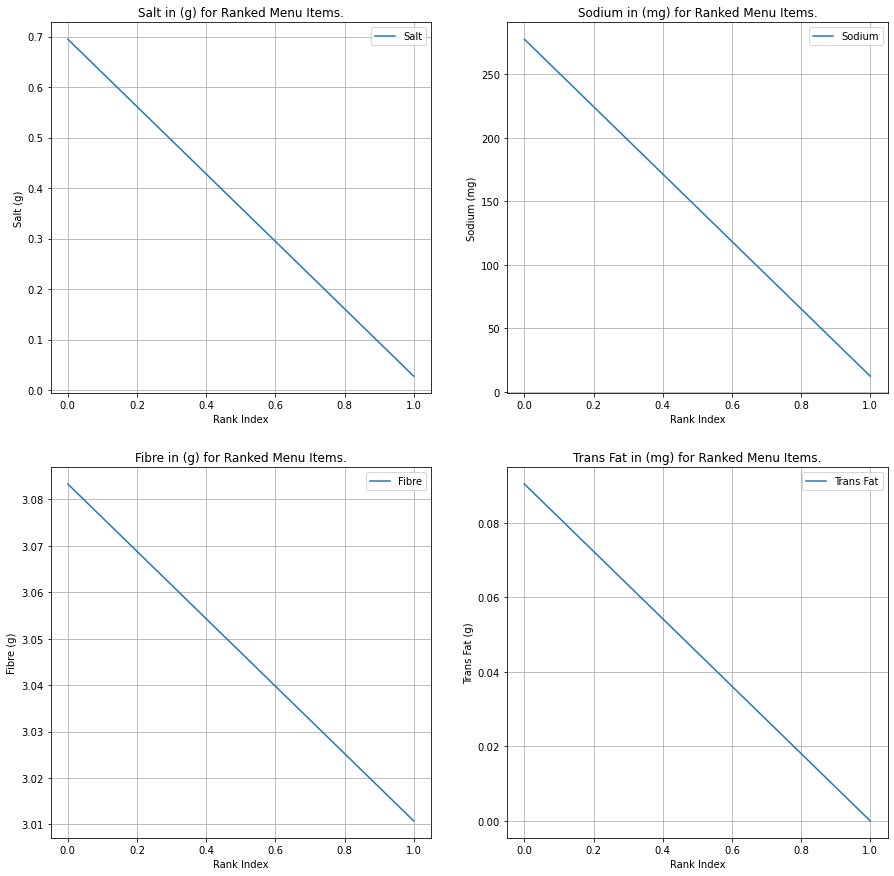

In [10]:
#Generate plots per nutrient
generate_plots(df_main, 'Salt', 'Sodium', 'Fibre', 'Trans Fat')

* Correlation Heat Map: Visualisation of the correlation of different nutrients with the target variable which is the eat-well score.

* Blue pixels indicate a negative correlation between the 2 parameters on x and y axis, grey pixels show that the 2 matched parameters are not correlated and orange/red pixels indicate a positive correlation. 

* On the first column of the heat map from the left, we see that Sodium and Salt have the strongest negative correlation with Eat-Well score, while for instance Pufa, Mufa, Omega 3 and Omega 6 have a weaker negative correlation. Fibre indicates a weak positive correlation.
    

<ipython-input-11-e900f240ee88>:5: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
<ipython-input-11-e900f240ee88>:5: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)


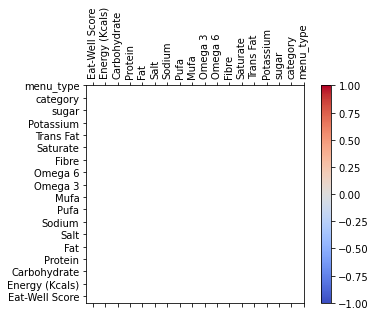

In [11]:
#Generate a Heat Map to examine correlation amongst different nutrients and the target variable, score.
corr = df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()

# Menu Items sorted by user's taste and preference based on Recommendations Algorithm

In [12]:
df = pd.DataFrame([allergens_free_menu_items, total_nutrition_values[0], scores]).T
df.columns = ["Menu-Items", "Ingredients", "Eat-Well Score"]

In [13]:
allergens_free_menu_items

['Cherry Shells', 'Coconut-Curry Wheat Berries and Rice']

# Menu Items sorted by Eat-Well score

In [14]:
#Eat-Well Re-ranked menu items 
df = df.sort_values(by ='Eat-Well Score', ascending=False).reset_index()
pd.set_option('max_colwidth', 400)
df

,index,Menu-Items,Ingredients,Eat-Well Score
0,1,Coconut-Curry Wheat Berries and Rice,"[ salt, vegetable oil, onion, curry powder, raisins, wheat berries, basmati rice, cilantro leaves, lemon, pepper]",0.890034
1,0,Cherry Shells,"[ cookie mix, cream cheese]",-2.640814


# With nutritional information

In [15]:
df_copy = pd.DataFrame([allergens_free_menu_items] + [scores] + [nutrition for nutrition in total_nutrition_values[1:]]).T
df_copy.columns = ['allergens_free_menu_items', 'Eat-Well Score', 'Energy', 'Carbohydrate', 'Protein', 'Fat', 'Salt', 'Sodium', 'Pufa', 'Mufa', 'Omega 3', 'Omega 6', 'Fibre', 'Saturate', 'Trans Fat', 'Potassium', 'Sugar', 'Category', 'Menu Type']
df_copy["Eat-Well Score"] = df_copy['Eat-Well Score'].astype(float)
#df_copy = df_copy.drop_duplicates(inplace=True)
df_copy = df_copy.sort_values(by='Eat-Well Score', ascending=False)
df_copy

,allergens_free_menu_items,Eat-Well Score,Energy,Carbohydrate,Protein,Fat,Salt,Sodium,Pufa,Mufa,Omega 3,Omega 6,Fibre,Saturate,Trans Fat,Potassium,Sugar,Category,Menu Type
1,Coconut-Curry Wheat Berries and Rice,0.890034,185.742,33.5383,4.491625,3.645,0.027725,12.3415,0.970045,1.89,0.3024,0.6543,3.01075,0.2804,0.0,184.677,7.32925,"[vegan, vegan, vegan, vegan, vegan, vegan, vegan, vegan, vegan, vegan]","[breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch]"
0,Cherry Shells,-2.640814,405.481667,54.788167,6.141333,17.071667,0.694733,277.516667,0.064033,0.527333,0.0,0.0,3.083333,7.227,0.0904,22.6,23.954833,"[dairy-vegetarian, vegan, dairy-vegetarian, vegan]","[breakfast, dessert, breakfast, dessert]"


# Meal planning

In [16]:
df, df_main, menu_items, total_nutrition_values, scores = get_menu_items([''], '', '', recommended_menu_items, nutrition_data_list, energy, energy_percent, meals_per_day)

1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002


## Breakfast options

In [17]:
from eat_well.eat_well_features import EatWellFeatures

energy_goal = energy-(energy * (energy_percent/100))/ meals_per_day

df, df_copy, menu_items, total_nutrition_values, scores = get_menu_items([''], '', 'lunch', recommended_menu_items, nutrition_data_list, energy, energy_percent, meals_per_day)
df_copy


1097.0528000000002
1097.0528000000002
1097.0528000000002
Skipping for meal Soft Cheese Board
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
Skipping for meal Cherry Shells
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
1097.0528000000002
Skipping for meal Coconut-Apricot Macaroons
1097.0528000000002
Skipping for meal Herb Coeur a La Creme
1097.0528000000002
Skipping for meal Honey Vanilla Fromage Blanc
1097.0528000000002
1097.0528000000002
1097.0528000000002
Skipping for meal Raspberry Vanilla Tartlets
1097.0528000000002
1097.0528000000002
1097.0528000000002


,allergens_free_menu_items,Eat-Well Score,Energy,Carbohydrate,Protein,Fat,Salt,Sodium,Pufa,Mufa,Omega 3,Omega 6,Fibre,Saturate,Trans Fat,Potassium,sugar,category,menu_type
13,Roasted Fingerling Potatoes with Fresh Herbs and Garlic,0.984351,371.645,39.665,5.8505,20.1505,0.1953,73.38,1.7476,14.6781,0.14,1.5,5.322,3.0506,0.0,1120.33,3.078,"[vegan, vegan, vegan, vegan, vegan, vegan, vegan]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]"
0,Tequila Laced Gazpacho Cocktails with Grilled Shrimp,0.973406,201.9885,14.93275,5.29525,8.49125,0.74635,306.6175,1.363375,4.428,0.342475,0.9044,6.1715,0.794175,0.0,1266.098,13.47025,"[vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]"
1,Curried Rice With Smoked Trout,0.892964,391.1125,58.871,14.10225,10.44025,0.2174,88.9225,0.5527,3.76155,0.035,0.484875,1.69375,2.47955,0.0,180.5125,1.984,"[vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]"
11,Coconut-Curry Wheat Berries and Rice,0.890034,185.742,33.5383,4.491625,3.645,0.027725,12.3415,0.970045,1.89,0.3024,0.6543,3.01075,0.2804,0.0,184.677,7.32925,"[vegan, vegan, vegan, vegan, vegan, vegan, vegan, vegan, vegan, vegan]","[breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch]"
4,Grilled Steak Fries with Citrus-Thyme Aioli,0.844178,745.415,52.415,5.482,56.645,0.194375,79.825,15.4067,34.4167,4.631,10.767,4.3245,4.2557,0.023,968.9275,7.603,"[vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]"
6,Grilled Fish Tacos with Vera Cruz Salsa,0.795521,276.792808,5.745243,29.436659,14.832462,0.357074,638.155717,1.890623,9.824467,0.11578,0.619593,1.338707,2.080513,0.0,771.348592,2.407416,"[vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]"
7,Roasted Beet and Lentil Dip,0.793343,117.235667,0.377333,1.574167,12.066667,0.0,0.763333,4.4411,5.492,0.6691,3.7475,0.571667,1.5339,0.0,48.6,0.212333,"[vegan, vegan, vegan, vegan, vegan, vegan, vegan]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]"
5,Spaghetti Aglio e Olio,0.754796,257.23875,0.224,0.4585,28.2225,0.0,2.6,2.31575,20.53125,0.196875,2.109375,0.386,4.022125,0.0,76.68,0.1935,"[vegan, vegan, vegan, vegan, vegan]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]"
12,Salami Salad,0.662269,332.4675,3.44475,8.555,30.5065,1.12235,453.34,3.0212,18.88495,0.265195,2.57985,3.25425,6.9398,0.042525,604.32,3.40

In [18]:
from math import floor
def x_round(x):
    return floor(x*4)/4

def portion_df(df, index, col, portion):
    df.loc[index, col] = portion * row[col]

#energy_per_meal = energy_goal/meals_per_day

def portion_control(df_copy, total_consumed_energy, energy_goal, mealtype):
    df_cols = df_copy.columns[2:-3]
    portion_list = []
    for index, row in df_copy.iterrows(): 
        if mealtype == "Breakfast":
            energy_to_be_consumed = energy_goal - total_consumed_energy
            meal_energy_required = energy_to_be_consumed / 3
        elif mealtype == "Lunch":
            energy_to_be_consumed = energy_goal - total_consumed_energy
            meal_energy_required = energy_to_be_consumed / 2
        elif mealtype == "Dinner":
            meal_energy_required = energy_goal - total_consumed_energy
        kcals = row['Energy']
        portion = meal_energy_required/kcals 
        portion = x_round(portion)
        portion_list.append(portion)
        if portion > 0.25:
            for col in df_cols:
                df_copy.loc[index, col] = portion * row[col]

    return portion_list

total_consumed_energy = 0
portion_list = portion_control(df_copy, total_consumed_energy, energy_goal, "Breakfast")

print('Here are the recommended kcals you should have, adjusted by portion size')
df_copy['Recommended portion size multiplier'] = portion_list
df_copy 

Here are the recommended kcals you should have, adjusted by portion size


,allergens_free_menu_items,Eat-Well Score,Energy,Carbohydrate,Protein,Fat,Salt,Sodium,Pufa,Mufa,Omega 3,Omega 6,Fibre,Saturate,Trans Fat,Potassium,sugar,category,menu_type,Recommended portion size multiplier
13,Roasted Fingerling Potatoes with Fresh Herbs and Garlic,0.984351,1022.02375,109.07875,16.088875,55.413875,0.537075,201.795,4.8059,40.364775,0.385,4.125,14.6355,8.38915,0.0,3080.9075,3.078,"[vegan, vegan, vegan, vegan, vegan, vegan, vegan]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",2.75
0,Tequila Laced Gazpacho Cocktails with Grilled Shrimp,0.973406,1009.9425,74.66375,26.47625,42.45625,3.73175,1533.0875,6.816875,22.14,1.712375,4.522,30.8575,3.970875,0.0,6330.49,13.47025,"[vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",5.00
1,Curried Rice With Smoked Trout,0.892964,977.78125,147.1775,35.255625,26.100625,0.5435,222.30625,1.38175,9.403875,0.0875,1.212187,4.234375,6.198875,0.0,451.28125,1.984,"[vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",2.50
11,Coconut-Curry Wheat Berries and Rice,0.890034,1021.581,184.46065,24.703937,20.0475,0.152487,67.87825,5.335247,10.395,1.6632,3.59865,16.559125,1.5422,0.0,1015.7235,7.32925,"[vegan, vegan, vegan, vegan, vegan, vegan, vegan, vegan, vegan, vegan]","[breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch]",5.50
4,Grilled Steak Fries with Citrus-Thyme Aioli,0.844178,931.76875,65.51875,6.8525,70.80625,0.242969,99.78125,19.258375,43.020875,5.78875,13.45875,5.405625,5.319625,0.02875,1211.159375,7.603,"[vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",1.25
6,Grilled Fish Tacos with Vera Cruz Salsa,0.795521,968.774829,20.108352,103.028307,51.913619,1.24976,2233.545008,6.617182,34.385633,0.40523,2.168577,4.685473,7.281797,0.0,2699.720071,2.407416,"[vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",3.50
7,Roasted Beet and Lentil Dip,0.793343,996.503167,3.207333,13.380417,102.566667,0.0,6.488333,37.74935,46.682,5.68735,31.85375,4.859167,13.03815,0.0,413.1,0.212333,"[vegan, vegan, vegan, vegan, vegan, vegan, vegan]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",8.50
5,Spaghetti Aglio e Olio,0.754796,964.645312,0.84,1.719375,105.834375,0.0,9.75,8.684062,76.992188,0.738281,7.910156,1.4475,15.082969,0.0,287.55,0.1935,"[vegan, vegan, vegan, vegan, vegan]","[lunch, dinner, lunch, dinner, lunch, 

We will provid the top 5 recommendations for this meal and try to hit overall calorie goals by the end of the day:

In [19]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def widget_options(list_val, desc):
    
    options = widgets.Dropdown(
        options=list(list_val),
        description=desc,
        disabled=False,
    )

    return options

print('Which meal would you like for breakfast?')
breakfast = widget_options(df_copy['allergens_free_menu_items'], 'Recipe:')
breakfast

Which meal would you like for breakfast?


Dropdown(description='Recipe:', options=('Roasted Fingerling Potatoes with Fresh Herbs and Garlic', 'Tequila L…

In [20]:
print(f'You selected \033[1m{breakfast.value}\033[0m for breakfast! Yummy. Would you like to adjust the portion size to what was recommended?')

adjust = widget_options(['yes', 'no'], 'Adjust?')
adjust
# meal_history = []
# meal_history.append(breakfast.value)
# meal_history.append(answers['breakfast'])


You selected Roasted Fingerling Potatoes with Fresh Herbs and Garlic for breakfast! Yummy. Would you like to adjust the portion size to what was recommended?


Dropdown(description='Adjust?', options=('yes', 'no'), value='yes')

In [21]:
def adjust_check(meal_history, mt, adjust, val):
    if adjust == 'yes': meal_history[mt] = [val, 'yes']
    else: meal_history[mt] = [val, 'no']

meal_history = {}
adjust_check(meal_history, 'breakfast', adjust.value, breakfast.value)

nutrient_history = []
if adjust.value == 'yes':
    breakfast_nutrient = df_copy.loc[df_copy['allergens_free_menu_items'] == str(list(meal_history.values())[0][0])]
    nutrient_history.append(breakfast_nutrient)
else: 
    breakfast_nutrient = df_copy.loc[df_main['allergens_free_menu_items'] == str(list(meal_history.values())[0][0])]
    nutrient_history.append(breakfast_nutrient)

energy = breakfast_nutrient['Energy']

print(f'Total kcals consumed so far is {round(float(list(energy)[0]))}')

Total kcals consumed so far is 1022


# Lunch options

In [22]:
df, df_copy, menu_items, total_nutrition_values, scores = get_menu_items([''], '', 'breakfast', recommended_menu_items, nutrition_data_list, energy, energy_percent, meals_per_day)
df_copy 

340.6745833333334
Skipping for meal Tequila Laced Gazpacho Cocktails with Grilled Shrimp
340.6745833333334
Skipping for meal Curried Rice With Smoked Trout
340.6745833333334
Skipping for meal Soft Cheese Board
340.6745833333334
Skipping for meal Thai Lettuce Wraps
340.6745833333334
Skipping for meal Adobo Buffalo Wings
340.6745833333334
Skipping for meal Grilled Steak Fries with Citrus-Thyme Aioli
340.6745833333334
340.6745833333334
Skipping for meal Spaghetti Aglio e Olio
340.6745833333334
Skipping for meal Grilled Fish Tacos with Vera Cruz Salsa
340.6745833333334
Skipping for meal Roasted Beet and Lentil Dip
340.6745833333334
Skipping for meal Greek Lamb Meatball Sliders with Tzatziki
340.6745833333334
Skipping for meal Coconut-Apricot Macaroons
340.6745833333334
Skipping for meal Herb Coeur a La Creme
340.6745833333334
Skipping for meal Honey Vanilla Fromage Blanc
340.6745833333334
Skipping for meal Latin Burgers with Caramelized Onion and Jalapeno Relish and Red Pepper Mayonnaise
3

,allergens_free_menu_items,Eat-Well Score,Energy,Carbohydrate,Protein,Fat,Salt,Sodium,Pufa,Mufa,Omega 3,Omega 6,Fibre,Saturate,Trans Fat,Potassium,sugar,category,menu_type
1,Coconut-Curry Wheat Berries and Rice,0.890034,185.742,33.5383,4.491625,3.645,0.027725,12.3415,0.970045,1.89,0.3024,0.6543,3.01075,0.2804,0.0,184.677,7.32925,"[vegan, vegan, vegan, vegan, vegan, vegan, vegan, vegan, vegan, vegan]","[breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch]"
0,Cherry Shells,-2.712243,405.481667,54.788167,6.141333,17.071667,0.694733,277.516667,0.064033,0.527333,0.0,0.0,3.083333,7.227,0.0904,22.6,23.954833,"[dairy-vegetarian, vegan, dairy-vegetarian, vegan]","[breakfast, dessert, breakfast, dessert]"


In [23]:
#Total energy intake so far (breakfast)
breakfast_energy = round(float(list(energy)[0]))
total_consumed_energy += breakfast_energy

portion_list = portion_control(df_copy, total_consumed_energy, energy_goal, "Lunch")
print('Here are the recommended kcals you should have, adjusted by portion size')
df_copy['Recommended portion size multiplier'] = portion_list
df_copy 

Here are the recommended kcals you should have, adjusted by portion size


,allergens_free_menu_items,Eat-Well Score,Energy,Carbohydrate,Protein,Fat,Salt,Sodium,Pufa,Mufa,Omega 3,Omega 6,Fibre,Saturate,Trans Fat,Potassium,sugar,category,menu_type,Recommended portion size multiplier
1,Coconut-Curry Wheat Berries and Rice,0.890034,1021.581,184.46065,24.703937,20.0475,0.152487,67.87825,5.335247,10.395,1.6632,3.59865,16.559125,1.5422,0.0,1015.7235,7.32925,"[vegan, vegan, vegan, vegan, vegan, vegan, vegan, vegan, vegan, vegan]","[breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch, breakfast, lunch]",5.5
0,Cherry Shells,-2.712243,1013.704167,136.970417,15.353333,42.679167,1.736833,693.791667,0.160083,1.318333,0.0,0.0,7.708333,18.0675,0.226,56.5,23.954833,"[dairy-vegetarian, vegan, dairy-vegetarian, vegan]","[breakfast, dessert, breakfast, dessert]",2.5


In [24]:
print('Which meal would you like?')
lunch = widget_options(df_copy['allergens_free_menu_items'], 'lunch')
lunch

Which meal would you like?


Dropdown(description='lunch', options=('Coconut-Curry Wheat Berries and Rice', 'Cherry Shells'), value='Coconu…

In [25]:
print(f'You selected \033[1m{lunch.value}\033[0m for lunch! Yummy. Would you like to adjust the portion size to what was recommended?')

adjust = widget_options(['yes', 'no'], 'Adjust?')
adjust

You selected Coconut-Curry Wheat Berries and Rice for lunch! Yummy. Would you like to adjust the portion size to what was recommended?


Dropdown(description='Adjust?', options=('yes', 'no'), value='yes')

In [26]:
# print(nutrient_history)
adjust_check(meal_history, 'lunch', adjust.value, lunch.value)

if adjust.value == 'yes':
    lunch_nutrient = df_copy.loc[df_copy['allergens_free_menu_items'] == str(list(meal_history.values())[1][0])]
    nutrient_history.append(lunch_nutrient)
else: 
    lunch_nutrient = df_copy.loc[df_main['allergens_free_menu_items'] == str(list(meal_history.values())[1][0])]
    nutrient_history.append(lunch_nutrient)

energy_list = []
energy_lunch = energy + round(list(nutrient_history[1]['Energy'])[0])
energy_list.append(list(energy)[0])
energy_list.append(list(nutrient_history[1]['Energy'])[0])

print(f'Total kcals consumed so far is {round(list(energy_lunch)[0])} kcals, only {energy_goal-round(list(energy_lunch)[0])} kcals to go')

Total kcals consumed so far is 2044 kcals, only 1027.74784 kcals to go


# Meal prediction for dinner

In [27]:
leftover_kcal = energy_goal - sum(energy_list)
print(f'Require {round(leftover_kcal)} kcals to meet your target.')
if leftover_kcal/energy_goal > 0.4:
    print(f'You have only had {100-round((leftover_kcal/energy_goal)*100)}% of your total intake!')
    print(f'You should consider having a snack to help meet your nutritional requirements for today ')

Require 1028 kcals to meet your target.


In [28]:
df, df_copy, menu_items, total_nutrition_values, scores = get_menu_items([''], '', 'dinner', recommended_menu_items, nutrition_data_list, energy, energy_percent, meals_per_day)

340.6745833333334
340.6745833333334
340.6745833333334
Skipping for meal Soft Cheese Board
340.6745833333334
340.6745833333334
340.6745833333334
340.6745833333334
Skipping for meal Cherry Shells
340.6745833333334
340.6745833333334
340.6745833333334
340.6745833333334
340.6745833333334
Skipping for meal Coconut-Apricot Macaroons
340.6745833333334
Skipping for meal Herb Coeur a La Creme
340.6745833333334
Skipping for meal Honey Vanilla Fromage Blanc
340.6745833333334
340.6745833333334
340.6745833333334
Skipping for meal Raspberry Vanilla Tartlets
340.6745833333334
Skipping for meal Coconut-Curry Wheat Berries and Rice
340.6745833333334
340.6745833333334


In [41]:
df_copy # Now we need to get the highest energy rated items and get enough of them as recommendations, alongside snacks or dessert if we can't make it to the kcals req

,allergens_free_menu_items,Eat-Well Score,Energy,Carbohydrate,Protein,Fat,Salt,Sodium,Pufa,Mufa,Omega 3,Omega 6,Fibre,Saturate,Trans Fat,Potassium,sugar,category,menu_type,Recommended portion size multiplier
0,Tequila Laced Gazpacho Cocktails with Grilled Shrimp,0.973406,1009.9425,74.66375,26.47625,42.45625,3.73175,1533.0875,6.816875,22.14,1.712375,4.522,30.8575,3.970875,0.0,6330.49,13.47025,"[vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",5.00
12,Roasted Fingerling Potatoes with Fresh Herbs and Garlic,0.912923,1022.02375,109.07875,16.088875,55.413875,0.537075,201.795,4.8059,40.364775,0.385,4.125,14.6355,8.38915,0.0,3080.9075,3.078,"[vegan, vegan, vegan, vegan, vegan, vegan, vegan]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",2.75
1,Curried Rice With Smoked Trout,0.821536,977.78125,147.1775,35.255625,26.100625,0.5435,222.30625,1.38175,9.403875,0.0875,1.212187,4.234375,6.198875,0.0,451.28125,1.984,"[vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",2.50
6,Grilled Fish Tacos with Vera Cruz Salsa,0.795521,968.774829,20.108352,103.028307,51.913619,1.24976,2233.545008,6.617182,34.385633,0.40523,2.168577,4.685473,7.281797,0.0,2699.720071,2.407416,"[vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",3.50
7,Roasted Beet and Lentil Dip,0.793343,1025.812083,3.301667,13.773958,105.583333,0.0,6.679167,38.859625,48.055,5.854625,32.790625,5.002083,13.421625,0.0,425.25,0.212333,"[vegan, vegan, vegan, vegan, vegan, vegan, vegan]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",8.75
4,Grilled Steak Fries with Citrus-Thyme Aioli,0.772749,931.76875,65.51875,6.8525,70.80625,0.242969,99.78125,19.258375,43.020875,5.78875,13.45875,5.405625,5.319625,0.02875,1211.159375,7.603,"[vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",1.25
5,Spaghetti Aglio e Olio,0.754796,964.645312,0.84,1.719375,105.834375,0.0,9.75,8.684062,76.992188,0.738281,7.910156,1.4475,15.082969,0.0,287.55,0.1935,"[vegan, vegan, vegan, vegan, vegan]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",3.75
11,Salami Salad,0.662269,997.4025,10.33425,25.665,91.5195,3.36705,1360.02,9.0636,56.65485,0.795585,7.73955,9.76275,20.8194,0.127575,1812.96,3.40125,"[dairy-vegetarian, vegan, meat, dairy-vegetarian, vegan, meat, dairy-vegetarian, vegan, meat, dairy-vegetarian, vegan, meat, dairy-vegetarian, vegan, meat, dairy-vegetarian, vegan, meat]","[lunch, dinner, lunch, dinner, lunch, dinner, l

In [30]:
portion_list = portion_control(df_copy, sum(energy_list), energy_goal, "Dinner")

print('Here are the recommended kcals you should have, adjusted by portion size')
df_copy['Recommended portion size multiplier'] = portion_list
df_copy 

Here are the recommended kcals you should have, adjusted by portion size


,allergens_free_menu_items,Eat-Well Score,Energy,Carbohydrate,Protein,Fat,Salt,Sodium,Pufa,Mufa,Omega 3,Omega 6,Fibre,Saturate,Trans Fat,Potassium,sugar,category,menu_type,Recommended portion size multiplier
0,Tequila Laced Gazpacho Cocktails with Grilled Shrimp,0.973406,1009.9425,74.66375,26.47625,42.45625,3.73175,1533.0875,6.816875,22.14,1.712375,4.522,30.8575,3.970875,0.0,6330.49,13.47025,"[vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",5.00
12,Roasted Fingerling Potatoes with Fresh Herbs and Garlic,0.912923,1022.02375,109.07875,16.088875,55.413875,0.537075,201.795,4.8059,40.364775,0.385,4.125,14.6355,8.38915,0.0,3080.9075,3.078,"[vegan, vegan, vegan, vegan, vegan, vegan, vegan]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",2.75
1,Curried Rice With Smoked Trout,0.821536,977.78125,147.1775,35.255625,26.100625,0.5435,222.30625,1.38175,9.403875,0.0875,1.212187,4.234375,6.198875,0.0,451.28125,1.984,"[vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian, vegan, seafood, ovo-vegetarian]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",2.50
6,Grilled Fish Tacos with Vera Cruz Salsa,0.795521,968.774829,20.108352,103.028307,51.913619,1.24976,2233.545008,6.617182,34.385633,0.40523,2.168577,4.685473,7.281797,0.0,2699.720071,2.407416,"[vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood, vegan, seafood]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",3.50
7,Roasted Beet and Lentil Dip,0.793343,1025.812083,3.301667,13.773958,105.583333,0.0,6.679167,38.859625,48.055,5.854625,32.790625,5.002083,13.421625,0.0,425.25,0.212333,"[vegan, vegan, vegan, vegan, vegan, vegan, vegan]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",8.75
4,Grilled Steak Fries with Citrus-Thyme Aioli,0.772749,931.76875,65.51875,6.8525,70.80625,0.242969,99.78125,19.258375,43.020875,5.78875,13.45875,5.405625,5.319625,0.02875,1211.159375,7.603,"[vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian, vegan, ovo-vegetarian]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",1.25
5,Spaghetti Aglio e Olio,0.754796,964.645312,0.84,1.719375,105.834375,0.0,9.75,8.684062,76.992188,0.738281,7.910156,1.4475,15.082969,0.0,287.55,0.1935,"[vegan, vegan, vegan, vegan, vegan]","[lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner, lunch, dinner]",3.75
11,Salami Salad,0.662269,997.4025,10.33425,25.665,91.5195,3.36705,1360.02,9.0636,56.65485,0.795585,7.73955,9.76275,20.8194,0.127575,1812.96,3.40125,"[dairy-vegetarian, vegan, meat, dairy-vegetarian, vegan, meat, dairy-vegetarian, vegan, meat, dairy-vegetarian, vegan, meat, dairy-vegetarian, vegan, meat, dairy-vegetarian, vegan, meat]","[lunch, dinner, lunch, dinner, lunch, dinner, l

In [31]:
print('Which meal would you like?')
dinner = widget_options(df_copy['allergens_free_menu_items'], 'dinner')
dinner

Which meal would you like?


Dropdown(description='dinner', options=('Tequila Laced Gazpacho Cocktails with Grilled Shrimp', 'Roasted Finge…

In [32]:
print(f'You selected \033[1m{dinner.value}\033[0m for dinner! Yummy. Would you like to adjust the portion size to what was recommended?')

adjust = widget_options(['yes', 'no'], 'Adjust?')
adjust

You selected Tequila Laced Gazpacho Cocktails with Grilled Shrimp for dinner! Yummy. Would you like to adjust the portion size to what was recommended?


Dropdown(description='Adjust?', options=('yes', 'no'), value='yes')

In [33]:

adjust_check(meal_history, 'dinner', adjust.value, dinner.value)

if adjust.value == 'yes':
    dinner_nutrient = df_copy.loc[df_copy['allergens_free_menu_items'] == str(list(meal_history.values())[2][0])]
    nutrient_history.append(dinner_nutrient)
else: 
    dinner_nutrient = df_copy.loc[df_main['allergens_free_menu_items'] == str(list(meal_history.values())[2][0])]
    nutrient_history.append(dinner_nutrient)


energy_list.append(list(nutrient_history[2]['Energy'])[0])

if energy_goal-round(sum(energy_list)) > 100:
    print(f'Total kcals consumed so far is {round(sum(energy_list))} kcals, only {energy_goal-round(sum(energy_list))} kcals to go')
else:
    print(f'Total kcals consumed so far is {round(sum(energy_list))} kcals, nice one!')

Total kcals consumed so far is 3054 kcals, nice one!


## Eat-Well Ranking Evaluation

* To evaluate eat-well algorithm scoring of various menu items, we calculate Rank-Biased Overlap (RBO) between 2 lists of items - eat-well rankings for a given set of menu items and the respective rankings for the same set of menu items generated by specialised nutritionists.

* RBO compares two ranked lists, and returns a numeric value between zero and one to quantify their similarity. A RBO value of zero indicates the lists are completely different, and a RBO of one means completely identical.

In [34]:
ground_truth_ratings = {
    "breakfast_seafood": [],
    "breakfast_vegetarian": [],
    "breakfast_ovo_vegetarian": [],
    "breakfast_dairy_vegetarian": [],
    "breakfast_vegetarian_only": [],
    "breakfast_vegan": [],
    "breakfast_omnivorous_meat_dishes_only": [],
    "all_breakfast_dishes": [],
    "lunch_seafood": ["Grilled fish tacos with Vera Cruz Salsa", "Curried rice with smoked trout", "Tequila laced Gazpacho Cocktails with grilled shrimp"],
    "lunch_vegetarian": [],
    "lunch_ovo_vegetarian": ["Grilled steak fries with citrus-thyme aioli"],
    "lunch_dairy_vegetarian": [],
    "lunch_vegetarian_only": [],
    "lunch_vegan": ["Coconut-curry wheat berries and rice", "Roasted beet and lentil dip", "Roasted fingerling potatoes"],
    "lunch_omnivorous_meat_dishes_only": ["Greek Lamb meatball sliders with tzatziki", "Salami salad", "Adobo Buffalo wings"],
    "all_lunch_dishes": ["Grilled fish tacos with Vera Cruz salsa", "Curried rice with smoked trout", "Coconut-curry wheat berries and rice", "Greek lamb meatball sliders with tzatziki", "Tequila laced Gazpacho cocktails with grilled shrimp", "Roasted beet and lentil dip", "roasted fingerling potatoes", "grilled steak fries with citrus-thyme aioli", "salami salad", "adobo buffalo wings"],
    "dinner_seafood": ["Grilled fish tacos with Vera Cruz Salsa", "Curried rice with smoked trout", "Tequila laced Gazpacho Cocktails with grilled shrimp", "Fool-i-ya-basie Seafood stew"],
    "dinner_vegetarian": [],
    "dinner_ovo_vegetarian": ["Grilled steak fries with citrus-thyme aioli"],
    "dinner_dairy_vegetarian": [],
    "dinner_vegetarian_only": [],
    "dinner_vegan": ["Coconut-curry wheat berries and rice", "Spaghetti Aglio e Olio"],
    "dinner_omnivorous_meat_dishes_only": ["Thai lettuce wraps", "Fool-i-ya-basie Seafoodstew", "Greek Lamb meatball sliders with tzatziki", "Salami salad", "Latin burgers with caramelised onion and jalapeno relish and red pepper mayonnaise", "Adobo Buffalo wings"],
    "all_dinner_dishes": ["Grilled fish tacos with Vera cruz salsa", "thai lettuce wraps", "curried rice with smoked trout", "Fool-i-ya-basie seafood stew", "Tequila laced gazpacho cocktails with grilled shrimp", "Greek lamb meatball sliders with tzatziki", "coconut-curry wheat berries and rice", "Latin Burgers with Caramelized Onion and Jalapeno Relish and Red Pepper Mayonnaise", "grilled steak fries with citrus-thyme aioli", "spaghetti aglio e olio", "adobo buffalo wings"]
    
}

In [42]:
eat_well_ratings = {
    "breakfast_seafood": ["Coconut-Curry Wheat Berries and Rice", "Cherry Shells"],
    "breakfast_vegetarian": ["Coconut-Curry Wheat Berries and Rice", "Cherry Shells"],
    "breakfast_ovo_vegetarian": [],
    "breakfast_dairy_vegetarian": [],
    "breakfast_vegetarian_only": [],
    "breakfast_vegan": ["Coconut-Curry Wheat Berries and Rice"],
    "breakfast_seafood_only": [],
    "breakfast_omnivorous_meat_dishes_only": [],
    "all_breakfast_dishes": ["Coconut-Curry Wheat Berries and Rice", "Cherry Shells"],
    "lunch_seafood": ["Roasted Fingerling Potatoes with Fresh Herbs and Garlic", "Curried Rice With Smoked Trout", "Roasted Beet and Lentil Dip", "Coconut-Curry Wheat Berries and Rice", "Tequila Laced Gazpacho Cocktails with Grilled Shrimp", "Grilled Fish Tacos with Vera Cruz Salsa", "Spaghetti Aglio e Olio", "Grilled Steak Fries with Citrus-Thyme Aioli"],
    "lunch_vegetarian": ["Roasted Fingerling Potatoes with Fresh Herbs and Garlic"],
    "lunch_ovo_vegetarian": [],
    "lunch_dairy_vegetarian": [],
    "lunch_vegetarian_only": [],
    "lunch_vegan": ["Roasted Fingerling Potatoes with Fresh Herbs and Garlic", "Coconut-Curry Wheat Berries and Rice", "Roasted Beet and Lentil Dip", "Spaghetti Aglio e Olio"],
    "lunch_seafood_only": ["Curried Rice With Smoked Trout", "Tequila Laced Gazpacho Cocktails with Grilled Shrimp", "Grilled Fish Tacos with Vera Cruz Salsa"],
    "lunch_omnivorous_meat_dishes_only": ["Salami Salad", "Latin Burgers with Caramelized Onion and Jalapeno Relish and Red Pepper Mayonnaise", "Fool-i-ya-baise Seafood Stew", "Greek Lamb Meatball Sliders with Tzatziki", "Thai Lettuce Wraps", "Adobo Buffalo Wings"],
    "all_lunch_dishes": ["Curried Rice With Smoked Trout", "Roasted Fingerling Potatoes with Fresh Herbs and Garlic", "Roasted Beet and Lentil Dip", "Grilled Fish Tacos with Vera Cruz Salsa", "Coconut-Curry Wheat Berries and Rice", "Spaghetti Aglio e Olio", "Tequila Laced Gazpacho Cocktails with Grilled Shrimp", "Fool-i-ya-baise Seafood Stew", "Grilled Steak Fries with Citrus-Thyme Aioli", "Salami Salad", "Latin Burgers with Caramelized Onion and Jalapeno Relish and Red Pepper Mayonnaise", "Thai Lettuce Wraps", "Greek Lamb Meatball Sliders with Tzatziki", "Adobo Buffalo Wings"],
    "dinner_seafood": ["Roasted Fingerling Potatoes with Fresh Herbs and Garlic", "Curried Rice With Smoked Trout", "Roasted Beet and Lentil Dip", "Tequila Laced Gazpacho Cocktails with Grilled Shrimp", "Grilled Fish Tacos with Vera Cruz Salsa", "Spaghetti Aglio e Olio", "Grilled Steak Fries with Citrus-Thyme Aioli"],
    "dinner_vegetarian": ["Roasted Fingerling Potatoes with Fresh Herbs and Garlic", "Roasted Beet and Lentil Dip", "Spaghetti Aglio e Olio", "Grilled Steak Fries with Citrus-Thyme Aioli"],
    "dinner_ovo_vegetarian": [],
    "dinner_dairy_vegetarian": [],
    "dinner_vegetarian_only": [],
    "dinner_vegan": ["Roasted Fingerling Potatoes with Fresh Herbs and Garlic", "Coconut-Curry Wheat Berries and Rice", "Roasted Beet and Lentil Dip", "Spaghetti Aglio e Olio"],
    "dinner_seafood_only": ["Curried Rice With Smoked Trout", "Tequila Laced Gazpacho Cocktails with Grilled Shrimp", "Grilled Fish Tacos with Vera Cruz Salsa"],
    "dinner_omnivorous_meat_dishes_only": ["Salami Salad", "Latin Burgers with Caramelized Onion and Jalapeno Relish and Red Pepper Mayonnaise", "Fool-i-ya-baise Seafood Stew", "Greek Lamb Meatball Sliders with Tzatziki", "Thai Lettuce Wraps", "Adobo Buffalo Wings"],
    "all_dinner_dishes": ['Tequila Laced Gazpacho Cocktails with Grilled Shrimp', 'Curried Rice With Smoked Trout', 'Thai Lettuce Wraps', 'Adobo Buffalo Wings',
 'Grilled Steak Fries with Citrus-Thyme Aioli', 'Spaghetti Aglio e Olio', 'Grilled Fish Tacos with Vera Cruz Salsa', 'Roasted Beet and Lentil Dip', 'Greek Lamb Meatball Sliders with Tzatziki', 'Latin Burgers with Caramelized Onion and Jalapeno Relish and Red Pepper Mayonnaise', 'Fool-i-ya-baise Seafood Stew', 'Salami Salad', 'Roasted Fingerling Potatoes with Fresh Herbs and Garlic']}

In [43]:
import math

def rbo(list1, list2, p=0.9):
   # tail recursive helper function
    def helper(ret, i, d):
        l1 = set(list1[:i]) if i < len(list1) else set(list1)
        l2 = set(list2[:i]) if i < len(list2) else set(list2)
        a_d = len(l1.intersection(l2))/i
        term = math.pow(p, i) * a_d
        if d == i:
            return ret + term
        return helper(ret + term, i + 1, d)
    k = max(len(list1), len(list2))
    x_k = len(set(list1).intersection(set(list2)))
    summation = helper(0, 1, k)
    return ((float(x_k)/k) * math.pow(p, k)) + ((1-p)/p * summation)

In [44]:
rbo([i.lower() for i in ground_truth_ratings["all_dinner_dishes"]], [i.lower() for i in eat_well_ratings["all_dinner_dishes"]])

0.5209070266184812